# K-Nearest Neighbors Algorithm Implementation in Python

In [46]:
import pickle
import time
import numpy as np
import pandas as pd
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
data = np.load('data.npy', allow_pickle=True)
# game_id , resnet(1 x 1024) , vit (1 x 512) , label_name , guess time

# 2.2 Exploratory Data Analysis
```
2.2.1 Task 1 [10]
```

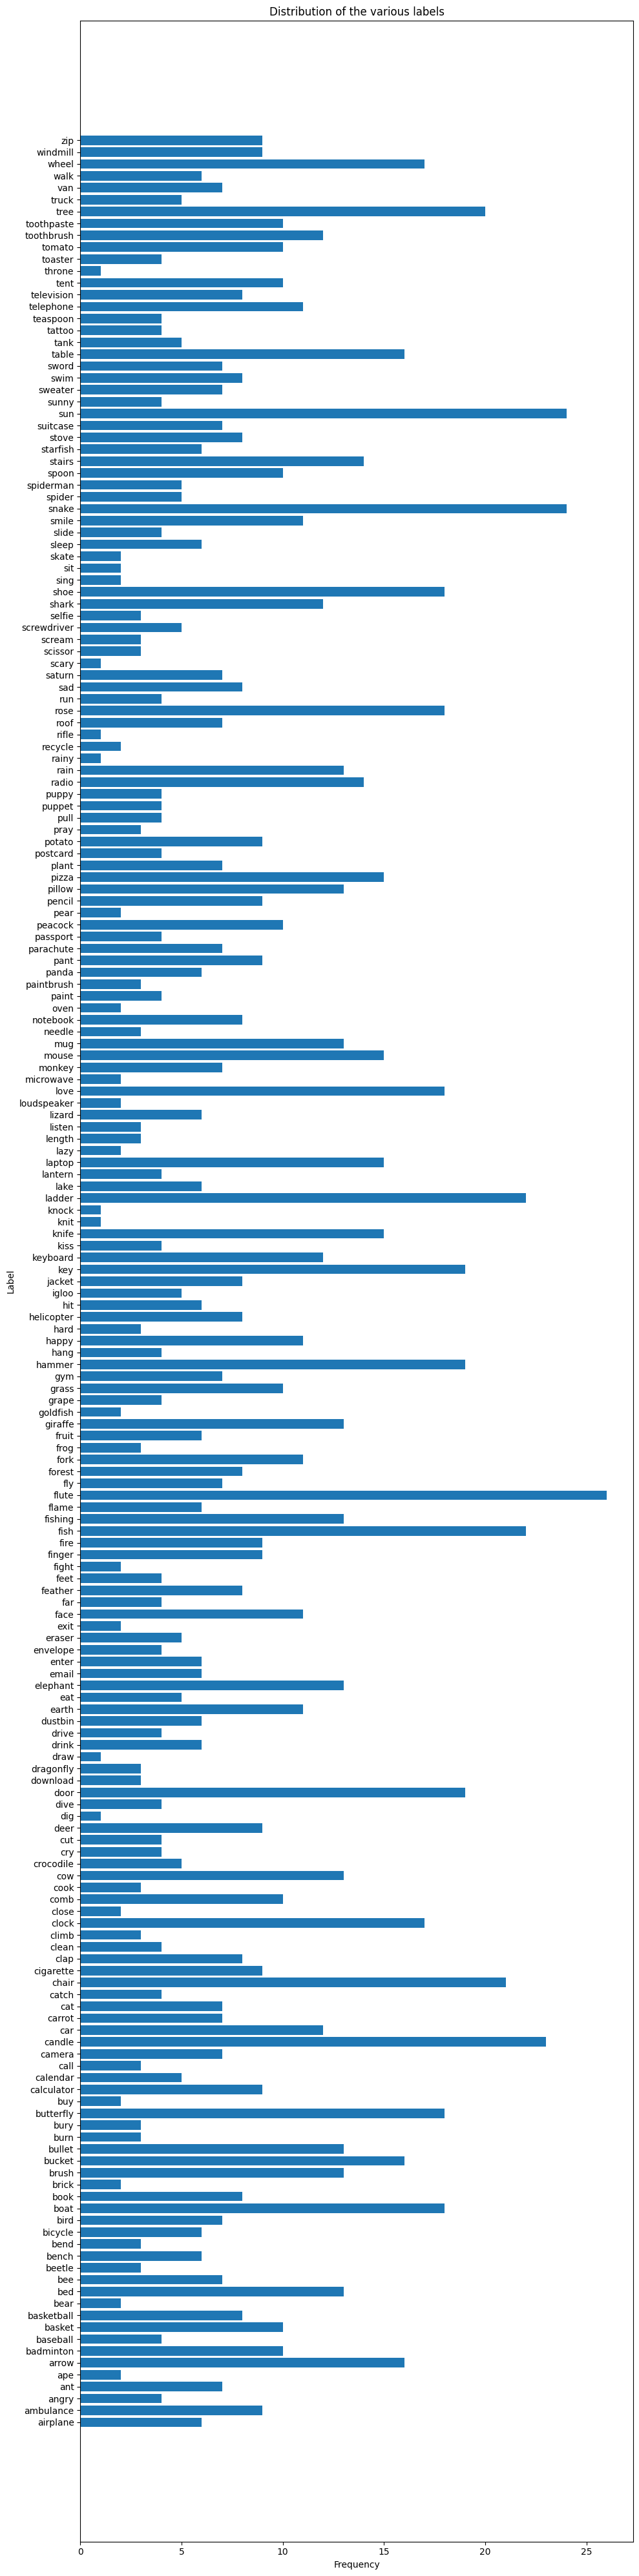

In [47]:
data_labels = np.array(data[:, 3])
values, counts = np.unique(data_labels, return_counts=True)
plt.figure(figsize=(10, 40))
plt.xlabel('Frequency')
plt.ylabel('Label')
plt.title('Distribution of the various labels')
plt.barh(values, counts)
plt.tight_layout()
plt.show()

# 2.3 KNN Implementation
```
2.3.1 Task 1 [30]
```

# Initial KNN Model

In [48]:
class Initial_KNN:
    def __init__(self, k, encoder_type, metric,ratio=0.8):
        self.k = k
        self.encoder_type = encoder_type
        self.metric = metric
        self.ratio = ratio

    def get_encoder_type(self):
        return self.encoder_type
    def set_encoder_type(self,encoder_type):
        self.encoder_type = encoder_type

    def get_metric(self):
        return self.metric
    def set_metric(self,metric):
        self.metric = metric

    def get_k(self): # get method for K
        return self.k
    def set_k(self,k): # set method for K
        self.k = k

    def get_ratio(self):
        return self.ratio
    def set_ratio(self,ratio):
        self.ratio = ratio


    def get_measure(self, A):
        unique_values, counts = np.unique(np.array(A), return_counts=True)
        return unique_values[np.argmax(counts)]

    def get_distance(self, E1, E2):
        if self.metric == 'manhattan':
            return np.sum(np.abs(np.array(E1) - np.array(E2)))
        elif self.metric == 'euclidean':
            return np.sqrt(np.sum(np.square(np.array(E1) - np.array(E2))))
        elif self.metric == 'cosine':
            return 1-(np.dot(E1,E2)) / (LA.norm(E1) * LA.norm(E2))
        else:
            raise ValueError("Unhandled Metric")
        
    def fit(self, train_embeddings, train_labels, validate_embeddings, validate_labels):
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
        self.validate_embeddings = validate_embeddings
        self.validate_labels = validate_labels

    def data_split(self,data):
        self.labels = np.array(data[:, 3])
        self.embeddings = np.array(data[:,1:3])
        self.resnet = np.array([res[0] for res in np.array(data[:,1])])
        self.vit = np.array([v[0] for v in np.array(data[:,2])])
        num_total_samples = data.shape[0]
        num_training_samples = int(num_total_samples * self.ratio)
        indices = np.array(range(num_total_samples)) # used to check if unshuffled data is giving same results across users
        np.random.seed(42)
        # np.random.shuffle(indices) # permutes the array [0,....n-1] 
        indices = np.random.permutation(indices) # permutes the array [0,....n-1] 
        self.indices = indices # saving indices
        self.num_training_samples = num_training_samples # saving number of training samples

    def evaluate(self, embeddings, true_labels):
        predicted_labels = self.predict(embeddings)
        return f1_score(true_labels, predicted_labels, average='macro'),accuracy_score(true_labels, predicted_labels),precision_score(true_labels, predicted_labels, average='macro',zero_division=0), recall_score(true_labels, predicted_labels, average='macro',zero_division=0)

    def train(self, encoder_type):
        if encoder_type == 'vit':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            self.fit(self.vit[train_index],self.labels[train_index],self.vit[validate_index],self.labels[validate_index])
        elif encoder_type == 'resnet':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            self.fit(self.resnet[train_index],self.labels[train_index],self.resnet[validate_index],self.labels[validate_index])

    def predict_sample(self, E):
        distances = [self.get_distance(embedding, E) for embedding in self.train_embeddings]
        sorted_indices = np.argsort(distances)
        return self.get_measure(self.train_labels[sorted_indices[:self.k]])

    def predict(self, X):
        predictions = [self.predict_sample(embeddings) for embeddings in X]
        return np.array(predictions)
    
    def print_answer(self,data):
        self.data_split(data)
        self.train(self.encoder_type)  
        F1_score, accuracy, precision, recall = self.evaluate(self.validate_embeddings, self.validate_labels)
        print(pd.DataFrame([['Accuracy',accuracy],['Precision',precision],['Recall',recall],['f1_score',F1_score]],columns=['Measure','Value']).to_string(index=False))
    
Initial_KNN_Object = Initial_KNN(3,'vit','manhattan')
Initial_KNN_Object.print_answer(data)

  Measure    Value
 Accuracy 0.223333
Precision 0.126320
   Recall 0.133446
 f1_score 0.116157


# Most Optimized KNN Model

In [49]:
class Optimized_KNN:
    def __init__(self, k, encoder_type, metric,ratio=0.8):
        self.k = k
        self.encoder_type = encoder_type
        self.metric = metric
        self.ratio = ratio

    def get_encoder_type(self):
        return self.encoder_type
    def set_encoder_type(self,encoder_type):
        self.encoder_type = encoder_type

    def get_metric(self):
        return self.metric
    def set_metric(self,metric):
        self.metric = metric

    def get_k(self): # get method for K
        return self.k
    def set_k(self,k): # set method for K
        self.k = k

    def get_ratio(self):
        return self.ratio
    def set_ratio(self,ratio):
        self.ratio = ratio

    def get_measure(self, A):
        unique_values, counts = np.unique(np.array(A), return_counts=True)
        return unique_values[np.argmax(counts)]

    def get_distance(self, E1, E2):
        if self.metric == 'manhattan':
            return LA.norm(np.array(E1)-np.array(E2),axis=1,ord=1)
        elif self.metric == 'euclidean':
            return LA.norm(np.array(E1)-np.array(E2),axis=1,ord=2)
        elif self.metric == 'cosine':
            return 1-(np.dot(np.array(E1),np.array(E2))) / (LA.norm(np.array(E1),axis=1) * LA.norm(np.array(E2)))
        else:
            raise ValueError("Unhandled Metric")
        
    def fit(self, train_embeddings, train_labels, validate_embeddings, validate_labels):
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
        self.validate_embeddings = validate_embeddings
        self.validate_labels = validate_labels

    def data_split(self,data):
        self.labels = np.array(data[:, 3])
        self.embeddings = np.array(data[:,1:3])
        self.resnet = np.array([res[0] for res in np.array(data[:,1])])
        self.vit = np.array([v[0] for v in np.array(data[:,2])])
        num_total_samples = data.shape[0]
        num_training_samples = int(num_total_samples * self.ratio)
        indices = np.array(range(num_total_samples)) # used to check if unshuffled data is giving same results across users
        np.random.seed(42)
        # np.random.shuffle(indices) # permutes the array [0,....n-1] 
        indices = np.random.permutation(indices) # permutes the array [0,....n-1] 
        self.indices = indices # saving indices
        self.num_training_samples = num_training_samples # saving number of training samples

    def evaluate(self, embeddings, true_labels):
        predicted_labels = self.predict(embeddings)
        return f1_score(true_labels, predicted_labels, average='macro'),accuracy_score(true_labels, predicted_labels),precision_score(true_labels, predicted_labels, average='macro',zero_division=0), recall_score(true_labels, predicted_labels, average='macro',zero_division=0)
    
    def train(self, encoder_type):
        if encoder_type == 'vit':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            self.fit(self.vit[train_index],self.labels[train_index],self.vit[validate_index],self.labels[validate_index])
        elif encoder_type == 'resnet':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:] 
            self.fit(self.resnet[train_index],self.labels[train_index],self.resnet[validate_index],self.labels[validate_index])

    def predict_sample(self, E):
        distances = self.get_distance(self.train_embeddings, E)
        sorted_indices = np.argsort(distances)
        return self.get_measure(self.train_labels[sorted_indices[:self.k]])

    def predict(self, X):
        predictions = [self.predict_sample(embeddings) for embeddings in X]
        return np.array(predictions)
    
    def print_answer(self,data):
        self.data_split(data)
        self.train(self.encoder_type)  
        F1_score, accuracy, precision, recall = self.evaluate(self.validate_embeddings, self.validate_labels)
        print(pd.DataFrame([['Accuracy',accuracy],['Precision',precision],['Recall',recall],['f1_score',F1_score]],columns=['Measure','Value']).to_string(index=False))
    
Optimized_KNN_Object = Optimized_KNN(3,'vit','manhattan')
Optimized_KNN_Object.print_answer(data)

  Measure    Value
 Accuracy 0.223333
Precision 0.126320
   Recall 0.133446
 f1_score 0.116157


# Best KNN Model

In [50]:
class Best_KNN:
    def __init__(self, k, encoder_type, metric,ratio=0.8):
        self.k = k
        self.encoder_type = encoder_type
        self.metric = metric
        self.ratio = ratio

    def get_encoder_type(self): # get method for encoder type
        return self.encoder_type
    def set_encoder_type(self,encoder_type): # set method for encoder type
        self.encoder_type = encoder_type

    def get_metric(self): # get method for metric
        return self.metric
    def set_metric(self,metric): # set method for metric
        self.metric = metric

    def get_k(self): # get method for K
        return self.k
    def set_k(self,k): # set method for K
        self.k = k

    def get_ratio(self): # get method for ratio
        return self.ratio
    def set_ratio(self,ratio): # set method for ratio
        self.ratio = ratio

    def get_measure(self, A):
        unique_values, counts = np.unique(np.array(A), return_counts=True) # Returns the sorted unique elements of an array.
        return unique_values[np.argmax(counts)] # argmax stores the index for max element in the array

    def get_distance(self, E1, E2): # vectorized code
        if self.metric == 'manhattan':
            return LA.norm(np.array(E1)-np.array(E2),axis=1,ord=1) # distance (x1,x2) -> |x1-x2|
        elif self.metric == 'euclidean':
            return LA.norm(np.array(E1)-np.array(E2),axis=1,ord=2)  # distance (x1,x2) -> sqrt((x1-x2)^2 + (y1-y2)^2 + ...)
        elif self.metric == 'cosine':
            return 1-(np.dot(np.array(E1),np.array(E2))) / (LA.norm(np.array(E1),axis=1) * LA.norm(np.array(E2))) # 1 - dot product
        else:
            raise ValueError("Unhandled Metric")
        
    def fit(self, train_embeddings, train_labels, validate_embeddings, validate_labels): # store data
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
        self.validate_embeddings = validate_embeddings
        self.validate_labels = validate_labels

    def data_split(self,data):
        self.labels = np.array(data[:, 3])
        self.embeddings = np.array(data[:,1:3])
        self.resnet = np.array([res[0] for res in np.array(data[:,1])])
        self.vit = np.array([v[0] for v in np.array(data[:,2])])
        num_total_samples = data.shape[0]
        num_training_samples = int(num_total_samples * self.ratio)
        indices = np.array(range(num_total_samples)) # used to check if unshuffled data is giving same results across users
        np.random.seed(42)
        # np.random.shuffle(indices) # permutes the array [0,....n-1] 
        indices = np.random.permutation(indices) # permutes the array [0,....n-1] 
        self.indices = indices # saving indices
        self.num_training_samples = num_training_samples # saving number of training samples

    def evaluate(self, embeddings, true_labels):
        predicted_labels = self.predict(embeddings)
        return f1_score(true_labels, predicted_labels, average='macro'),accuracy_score(true_labels, predicted_labels),precision_score(true_labels, predicted_labels, average='macro',zero_division=0), recall_score(true_labels, predicted_labels, average='macro',zero_division=0)

    def train(self, encoder_type):
        if encoder_type == 'vit':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            self.fit(self.vit[train_index],self.labels[train_index],self.vit[validate_index],self.labels[validate_index])
        elif encoder_type == 'resnet':
            train_index = self.indices[:self.num_training_samples]
            validate_index = self.indices[self.num_training_samples:]
            self.fit(self.resnet[train_index],self.labels[train_index],self.resnet[validate_index],self.labels[validate_index])

    def predict_sample(self, E):
        distances = self.get_distance(self.train_embeddings, E) # Using axis = 1 and calculating distances in 1-go
        sorted_indices = np.argsort(distances) # indexes in sorted array
        return self.get_measure(self.train_labels[sorted_indices[:self.k]])

    def predict(self, X):
        return np.array([self.predict_sample(embeddings) for embeddings in X])
    
    def print_answer(self,data):
        self.data_split(data)
        self.train(self.encoder_type)  
        F1_score, accuracy, precision, recall = self.evaluate(self.validate_embeddings, self.validate_labels)
        print(pd.DataFrame([['Accuracy',accuracy],['Precision',precision],['Recall',recall],['f1_score',F1_score]],columns=['Measure','Value']).to_string(index=False))
    
Best_KNN_Object = Best_KNN(3,'vit','manhattan')
Best_KNN_Object.print_answer(data)

  Measure    Value
 Accuracy 0.223333
Precision 0.126320
   Recall 0.133446
 f1_score 0.116157


# 2.4 - Hyperparameter Tuning
```
Task 2[30] - 2.4.1
```

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37]
------------------------------
 Best Accuracy  k    Metric Encoder-Type
      0.276667  7 manhattan          vit
------------------------------
 Accuracy  k    Metric Encoder-Type
 0.276667  7 manhattan          vit
 0.263333  1 euclidean          vit
 0.263333  7    cosine          vit
 0.260000  1 manhattan          vit
 0.256667  1    cosine          vit
 0.256667  7 euclidean          vit
 0.246667  4 manhattan          vit
 0.246667  4 euclidean          vit
 0.243333 10    cosine          vit
 0.243333 19 manhattan          vit
 0.243333 28 manhattan          vit
 0.240000 10 euclidean          vit
 0.240000 13 manhattan          vit
 0.240000 13    cosine          vit
 0.240000 16 manhattan          vit
 0.240000 28 euclidean          vit
 0.240000 31 manhattan          vit
 0.240000 34 manhattan          vit
 0.240000 37 manhattan          vit
 0.236667 19 euclidean          vit
------------------------------


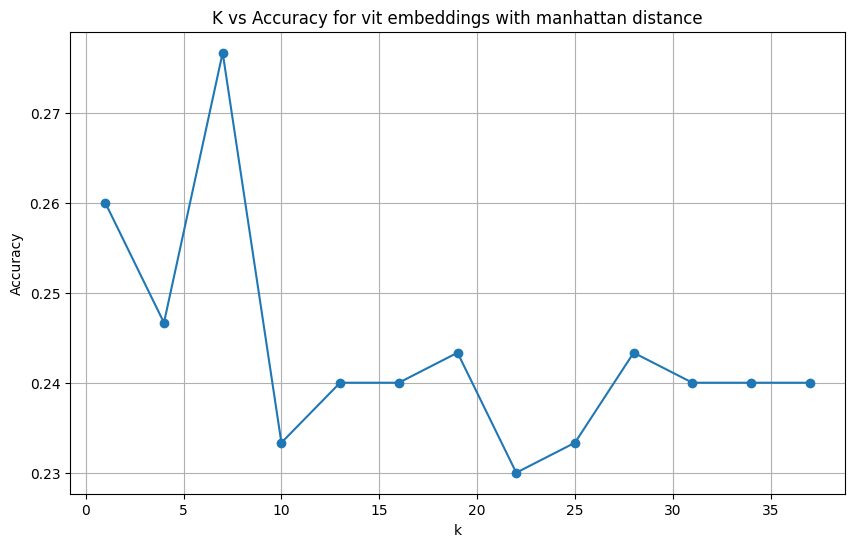

In [51]:
Hyper_parameter_KNN = Optimized_KNN(3,'vit','manhattan')
K = []
for k in range(1,40,3):
    K.append(k)
print(K)
metric = ['manhattan','euclidean','cosine']
encoder_type = ['vit','resnet']
Hyper_parameter_KNN.data_split(data)
tuples = []
for k in K:
    for metric_type in metric:
        for encoder in encoder_type:
            Hyper_parameter_KNN.set_encoder_type(encoder)
            Hyper_parameter_KNN.set_k(k)
            Hyper_parameter_KNN.set_metric(metric_type)
            Hyper_parameter_KNN.train(Hyper_parameter_KNN.get_encoder_type())
            F1_score, accuracy, precision, recall = Hyper_parameter_KNN.evaluate(Hyper_parameter_KNN.validate_embeddings, Hyper_parameter_KNN.validate_labels)
            tuples.append((accuracy,k,metric_type,encoder))

sorted_tuples = sorted(tuples, key=lambda x: x[0], reverse=True)
best_triplet = sorted_tuples[0]
df = pd.DataFrame(sorted_tuples[:1], columns=['Best Accuracy', 'k', 'Metric', 'Encoder-Type'])
print('------------------------------')
print(df.to_string(index=False))
print('------------------------------')
df = pd.DataFrame(sorted_tuples[:20], columns=['Accuracy', 'k', 'Metric', 'Encoder-Type'])
print(df.to_string(index=False))
given_metric = 'manhattan'
given_encoder_type = 'vit'
k_tuples = sorted(sorted_tuples, key=lambda x: x[1])
filtered_tuples = [(accuracy, k, metric, encoder_type) for accuracy, k, metric, encoder_type in k_tuples
                 if metric == given_metric and encoder_type == given_encoder_type]
filtered_df = pd.DataFrame(filtered_tuples, columns=['Accuracy', 'k', 'Metric', 'Encoder Type'])
print('------------------------------')
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['k'], filtered_df['Accuracy'], marker='o')
plt.title(f'K vs Accuracy for {given_encoder_type} embeddings with {given_metric} distance')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# filtered_tuples = [(accuracy, k, metric, encoder_type) for accuracy, k, metric, encoder_type in k_tuples
#                  if encoder_type == 'resnet']
# sorted_resnet_tuples = sorted(filtered_tuples, key=lambda x: x[0], reverse=True)
# df = pd.DataFrame(sorted_resnet_tuples, columns=['Best Accuracy', 'k', 'Metric', 'Encoder-Type'])
# print('------------------------------')
# print(df.to_string(index=False))
# print('------------------------------')

# 2.6 - Optimization
```
2.6.1 Tasks [30]
```

# Inference Time vs Model
```
Using axis=1 in the get_distance method takes advantage of vectorization, enabling efficient and parallelized calculations of distances between entire embedding vectors, leading to faster execution times.
```

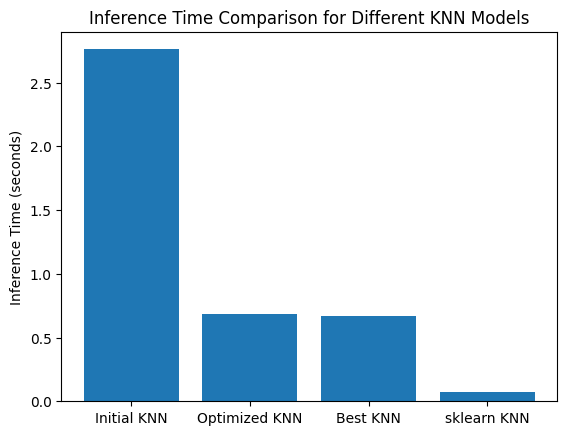

In [52]:
sklearn_knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
models = [Initial_KNN_Object,Optimized_KNN_Object,Best_KNN_Object]
inference_times = []
for model in models:
    model.data_split(data)
    model.train(model.encoder_type)  
    start_time = time.time()
    model.predict(model.validate_embeddings)
    end_time = time.time()
    inference_times.append(end_time - start_time) 
start_time = time.time()
sklearn_knn.fit(Initial_KNN_Object.train_embeddings,Initial_KNN_Object.train_labels)
sklearn_knn.predict(Initial_KNN_Object.validate_embeddings)
end_time = time.time()
inference_times.append(end_time - start_time)
model_names = ['Initial KNN','Optimized KNN','Best KNN','sklearn KNN']
plt.bar(model_names, inference_times)
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison for Different KNN Models')
plt.show()

# Train_dataset_size vs Inference Time - Same Sample SIze

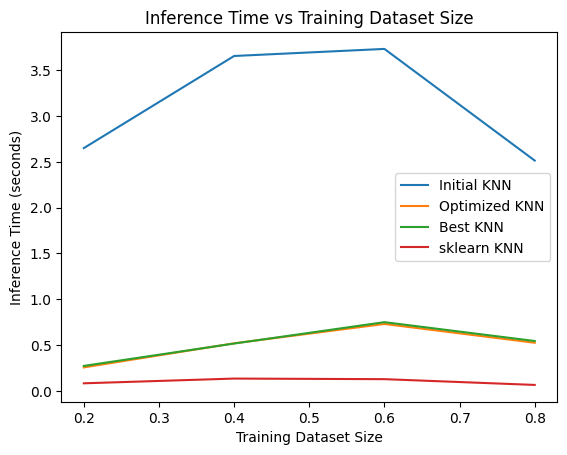

In [53]:
ratios = [0.2,0.4,0.6,0.8]
sklearn_knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
models = [Initial_KNN_Object,Optimized_KNN_Object,Best_KNN_Object,sklearn_knn]
model_names = ['Initial KNN', 'Optimized KNN', 'Best KNN', 'sklearn KNN']
inference_times = {model: [] for model in models}
size = data.shape[0]
for ratio in ratios:    
    for model in models:
        if model is sklearn_knn:
            break
        model.set_ratio(ratio)
        model.data_split(data)
        model.train(model.encoder_type)  
        start_time = time.time()
        model.predict(model.validate_embeddings)
        end_time = time.time()
        inference_times[model].append(end_time - start_time)

sklearn_knn_inference_times = []
for ratio in ratios:
    Initial_KNN_Object.set_ratio(ratio)
    Initial_KNN_Object.data_split(data)
    Initial_KNN_Object.train(Initial_KNN_Object.encoder_type)
    sklearn_knn.fit(Initial_KNN_Object.train_embeddings,Initial_KNN_Object.train_labels)
    start_time = time.time()
    sklearn_knn.predict(Initial_KNN_Object.validate_embeddings)
    end_time = time.time()
    sklearn_knn_inference_times.append(end_time - start_time)

inference_times[sklearn_knn] = sklearn_knn_inference_times
for model, times in inference_times.items():
    plt.plot(ratios, times, label=model_names[models.index(model)])
plt.xlabel('Training Dataset Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs Training Dataset Size')
plt.legend()
plt.show()

# Train_dataset_size vs Inference Time - Varying Sample Size
```
The graph of time complexity versus the number of samples would generally show an increasing trend. 
As the number of samples (N) increases, the time complexity tends to increase as well. 
This is because both the distance calculation and the sorting steps have dependencies on the number of samples.
The growth rate could be roughly linear for small datasets, but it might become more pronounced and closer to quadratic as the dataset size increases.
```

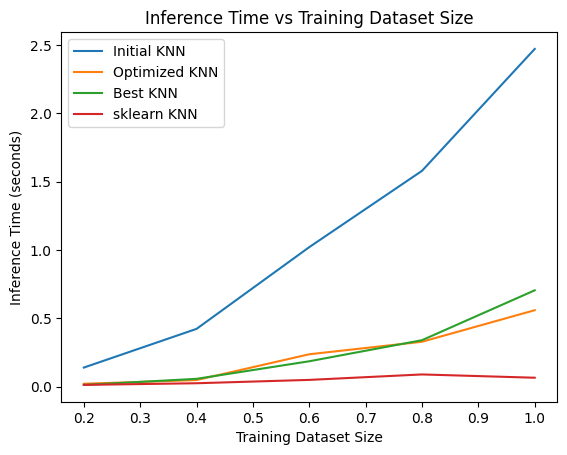

In [54]:
ratios = [0.2,0.4,0.6,0.8,1]
sklearn_knn = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
models = [Initial_KNN_Object,Optimized_KNN_Object,Best_KNN_Object,sklearn_knn]
model_names = ['Initial KNN', 'Optimized KNN', 'Best KNN', 'sklearn KNN']
inference_times = {model: [] for model in models}
size = data.shape[0]
data_size = len(data)
for ratio in ratios:    
    for model in models:
        if model is sklearn_knn:
            break
        new_size = int(data_size*ratio)
        # print(new_size)
        new_data = np.array(data)[:new_size]
        # model.set_ratio(ratio)
        model.data_split(new_data)
        model.train(model.encoder_type)  
        start_time = time.time()
        model.predict(model.validate_embeddings)
        end_time = time.time()
        inference_times[model].append(end_time - start_time)

sklearn_knn_inference_times = []
for ratio in ratios:
    Initial_KNN_Object.set_ratio(0.8)
    new_size = int(data_size*ratio)
    # print(new_size)
    new_data = np.array(data)[:new_size]
    Initial_KNN_Object.data_split(new_data)
    Initial_KNN_Object.train(Initial_KNN_Object.encoder_type)
    # print(len(Initial_KNN_Object.train_labels))
    sklearn_knn.fit(Initial_KNN_Object.train_embeddings,Initial_KNN_Object.train_labels)
    start_time = time.time()
    # print(len(Initial_KNN_Object.validate_embeddings))
    sklearn_knn.predict(Initial_KNN_Object.validate_embeddings)
    end_time = time.time()
    sklearn_knn_inference_times.append(end_time - start_time)

inference_times[sklearn_knn] = sklearn_knn_inference_times
for model, times in inference_times.items():
    plt.plot(ratios, times, label=model_names[models.index(model)])
plt.xlabel('Training Dataset Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs Training Dataset Size')
plt.legend()
plt.show()

#  Decision Tree Implementation in Python

# 3.3 MultiLabel Classification
```
3.3.1 Tasks[50]
```

# Data Visualization

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home
...,...,...,...,...,...,...,...,...,...,...,...
995,61,Male,34246.773063,Master,True,3,Solisfurt,HR,103.357441,bed,food furniture
996,56,Female,45494.225591,Bachelor,False,0,Dawsonmouth,Engineer,85.159023,biscuits,home clothing food
997,64,Female,68740.442006,PhD,True,0,Lake Garyport,Salesman,101.434650,bat,sports clothing
998,18,Female,44348.446680,Bachelor,True,0,Ericfurt,Retired,97.649988,perfume,beauty


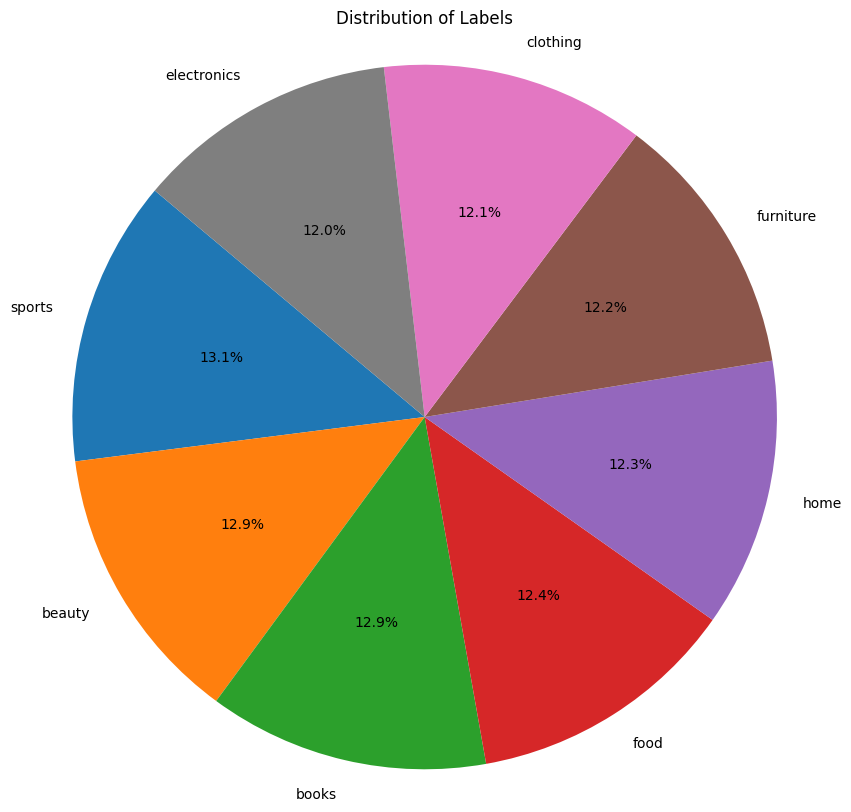

In [55]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score , confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
data = pd.read_csv('advertisement.csv') # reading data
display(data)
all_labels = ' '.join(data['labels']).split()
label_counts = pd.Series(all_labels).value_counts()
plt.figure(figsize=(10, 10))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Distribution of Labels')
plt.show()

# Data preprocessing

In [56]:
data.dropna(inplace=True)

# Data featurization

In [57]:
numerical_features = ['age', 'income', 'children', 'purchase_amount'] # numerical features
target_columns = ['labels']
one_hot_encoding = pd.get_dummies(data,columns=['gender', 'education', 'married', 'city', 'occupation', 'most bought item'],drop_first=True) # one hot encoding of categorical features
# print(one_hot_encoding.head())

# 3.4 Hyperparamter Tuning
```
3.4.1 Task[50]
```

# Train val test splitting - MultiOutput Formulation

In [58]:
def Multi_Output_data_split():
        X = one_hot_encoding.drop('labels',axis=1)
        y = one_hot_encoding['labels']
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42) 
        mlb = MultiLabelBinarizer()  # Transform between iterable of iterables and a multilabel format.
        y_train = mlb.fit_transform(y_train.str.split(' '))
        y_test = mlb.transform(y_test.str.split(' '))
        return X_train,X_test,y_train,y_test


class Multi_Output_DecisionTree:
    def __init__(self,criterion='gini',max_depth=3,max_features=None):
        self.criterion = criterion # criterion
        self.max_depth = max_depth # max_depth
        self.max_features = max_features # max_features
        self.classifier = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,max_features=max_features,random_state=42)  # classifier stored in class
    def fit(self,X_train,y_train): # fit 
        self.classifier.fit(X_train,y_train)
    def predict(self,X_test): # predict
        predicted_labels = self.classifier.predict(X_test)
        return predicted_labels
    def print_answer(self,y_test,predicted_labels):
        accuracy = accuracy_score(y_test,predicted_labels)
        f1_micro = f1_score(y_test, predicted_labels, average='micro',zero_division=0) # harmonic mean of the precision and recall , Calculate metrics globally by counting the total true positives, false negatives and false positives.
        f1_macro = f1_score(y_test, predicted_labels, average='macro',zero_division=0) # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        precision = precision_score(y_test, predicted_labels, average='macro',zero_division=0) # tp / (tp + fp)
        recall = recall_score(y_test, predicted_labels, average='macro',zero_division=0) # tp / (tp + fn)
        Confusion_matrix = confusion_matrix(y_test.argmax(axis=1),predicted_labels.argmax(axis=1)) # To evaluate accuracy
        return accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix
    def change_parameters(self,criterion,max_depth,max_features):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        self.classifier.set_params(criterion=self.criterion,max_depth=self.max_depth,max_features=self.max_features,random_state=42) # Set the parameters of this estimator.

# Hyperparameter Tuning - MultiOutput Formulation

In [59]:
criterion = ['gini','entropy']
max_depths = [3,5,10,20,30]
max_features = [3,5,7,9,11]
tuples = [] # tuples to store measures
clf = Multi_Output_DecisionTree()
X_train,X_test,y_train,y_test = Multi_Output_data_split() # preprocesses data and uses train_test_split to divide and shuffle dataset in 80-20 ratio
for criteria in criterion:
    for depth in max_depths:
        for feature in max_features:
            clf.change_parameters(criteria,depth,feature)
            clf.fit(X_train,y_train) # Build a decision tree classifier from the training set (X, y).
            predicted_labels = clf.predict(X_test) # predict class or regression value for X
            accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix = clf.print_answer(y_test,predicted_labels)
            tuples.append((criteria,depth,feature,accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix))
# (accuracy,f1_micro,f1_macro,precision,recall)
df = pd.DataFrame(tuples, columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix'])
# print(df.to_string(index=False))
sorted_f1_micro_tuples = sorted(tuples, key=lambda x: x[4], reverse=True) # top f1_micro tuples
sorted_f1_macro_tuples = sorted(tuples, key=lambda x: x[5], reverse=True) # top f1_macro tuples
multi_fold_criteria = sorted_f1_macro_tuples[0][0] # storing criterion of best tuple
multi_fold_depth = sorted_f1_macro_tuples[0][1] # storing max_depth of best tuple
multi_fold_features = sorted_f1_macro_tuples[0][2] # storing max_features of best tuple
print('----------------------------')
print('Top 3 performing set of hyperparamters according to F1-micro Score')
df = pd.DataFrame(sorted_f1_micro_tuples[:3], columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix']) # Top-3 f1_micro tuples
print(df.to_string(index=False))
print('----------------------------')
print('Top 3 performing set of hyperparamters according to F1-macro Score')
df = pd.DataFrame(sorted_f1_macro_tuples[:3], columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix']) # Top-3 f1_macro tuples
print(df.to_string(index=False))

----------------------------
Top 3 performing set of hyperparamters according to F1-micro Score
Criteria  Max-Depth  Max-features  Accuracy  f1_micro_score  f1_macro_score  precision   recall                                                                                                                                                                                                      Confusion_matrix
 entropy         30            11     0.020        0.279412        0.278655   0.405746 0.216752 [[54, 7, 2, 4, 0, 1, 0, 0], [35, 4, 5, 1, 1, 0, 0, 0], [18, 1, 4, 2, 2, 0, 0, 0], [12, 2, 3, 3, 0, 2, 0, 0], [11, 0, 1, 5, 1, 0, 0, 0], [6, 1, 0, 0, 0, 1, 0, 0], [2, 1, 1, 1, 0, 0, 0, 0], [4, 0, 1, 1, 0, 0, 0, 0]]
    gini         30            11     0.005        0.228731        0.220438   0.402976 0.156048 [[61, 3, 2, 2, 0, 0, 0, 0], [40, 0, 1, 3, 2, 0, 0, 0], [24, 3, 0, 0, 0, 0, 0, 0], [15, 3, 1, 2, 0, 1, 0, 0], [14, 0, 2, 2, 0, 0, 0, 0], [6, 1, 1, 0, 0, 0, 0, 0], [5, 0, 0, 0, 0, 0, 0, 0], 

# Train val test splitting - Powerset Formulation

In [60]:
def Power_set_data_split():
    X = one_hot_encoding.drop('labels',axis=1)
    distinct_labels = set()
    # Each row is split into vector of strings , then sorted and then made a string again , so as to ensure lack of redundancy
    for label_set in data['labels']:
        labels = label_set.split()
        distinct_labels.update(labels)
    powerset_labels = []
    size = 2 ** len(distinct_labels)
    for r in range(size):
        # I have referred CHATGPT to enumerate all the possible subsets here , the idea is mine , but I had some difficulty in implementation
        label_indices = [i for i in range(len(distinct_labels)) if (r & (1 << i)) > 0]
        label_combination = [list(distinct_labels)[idx] for idx in label_indices]
        powerset_labels.append(label_combination)
    sorted_powerset_labels = [' '.join(sorted(label_set)) for label_set in powerset_labels]
    sorted_powerset_labels.sort() # powerset which is lexograhically sorted
    label_to_idx = {label: idx for idx, label in enumerate(sorted_powerset_labels)} # map to store indexes vs set
    label_vectors = np.zeros((len(data), len(powerset_labels)))
    for idx, label_set in enumerate(data['labels']):
        labels = label_set.split()
        sorted_labels = ' '.join(sorted(labels))
        label_vectors[idx, label_to_idx[sorted_labels]] = 1 # designing row vectors similar to multilabel binarizer
    y = label_vectors
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train,X_test,y_train,y_test

class Powerset_DecisionTree:
    def __init__(self,criterion='gini',max_depth=3,max_features=None):
        self.criterion = criterion # criteria 
        self.max_depth = max_depth # max_depth 
        self.max_features = max_features # max_features
        self.classifier = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,max_features=max_features,random_state=42) # classifier stored in class
    def fit(self,X_train,y_train): # fit 
        self.classifier.fit(X_train,y_train)
    def predict(self,X_test): # predict
        predicted_labels = self.classifier.predict(X_test)
        return predicted_labels
    def print_answer(self,y_test,predicted_labels):
        accuracy = accuracy_score(y_test,predicted_labels)
        f1_micro = f1_score(y_test, predicted_labels, average='micro',zero_division=0) # harmonic mean of the precision and recall , Calculate metrics globally by counting the total true positives, false negatives and false positives.
        f1_macro = f1_score(y_test, predicted_labels, average='macro',zero_division=0) # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        precision = precision_score(y_test, predicted_labels, average='macro',zero_division=0) # tp / (tp + fp)
        recall = recall_score(y_test, predicted_labels, average='macro',zero_division=0) # tp / (tp + fn)
        Confusion_matrix = confusion_matrix(y_test.argmax(axis=1),predicted_labels.argmax(axis=1)) # confusion matrix to evaluate the accuracy of a classification.
        return accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix
    def change_parameters(self,criterion,max_depth,max_features):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features
        self.classifier.set_params(criterion=self.criterion,max_depth=self.max_depth,max_features=self.max_features,random_state=42) # Set the parameters of this estimator.

# Hyperparameter Tuning - Powerset Formulation

In [61]:
criterion = ['gini','entropy']
max_depths = [3,5,10,20,30]
max_features = [3,5,7,9,11]
tuples = [] # tuples to store metrics
clf = Powerset_DecisionTree()
X_train,X_test,y_train,y_test = Power_set_data_split() # preprocesses the data and splits in 80-20 ratio
for criteria in criterion:
    for depth in max_depths:
        for feature in max_features:
            clf.change_parameters(criteria,depth,feature) # change parameters as part of iteration
            clf.fit(X_train,y_train) # Build a decision tree classifier from the training set (X, y).
            predicted_labels = clf.predict(X_test) # Predict class or regression value for X.
            accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix = clf.print_answer(y_test,predicted_labels)
            tuples.append((criteria,depth,feature,accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix))
# (accuracy,f1_micro,f1_macro,precision,recall)
df = pd.DataFrame(tuples, columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix']) # pandas dataframe
# print(df.to_string(index=False))
sorted_f1_micro_tuples = sorted(tuples, key=lambda x: x[4], reverse=True) # sorting based on f1_micro score
sorted_f1_macro_tuples = sorted(tuples, key=lambda x: x[5], reverse=True) # sorting based on f1_macro score
power_fold_criteria = sorted_f1_macro_tuples[0][0] # storing criterion of best tuple
power_fold_depth = sorted_f1_macro_tuples[0][1] # storing max_depth of best tuple
power_fold_features = sorted_f1_macro_tuples[0][2] # storing max_features of best tuple
print('----------------------------')
print('Top 3 performing set of hyperparamters according to F1-micro Score')
df = pd.DataFrame(sorted_f1_micro_tuples[:3], columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix']) # Top-3 f1_micro tuples
print(df.to_string(index=False))
print('----------------------------')
print('Top 3 performing set of hyperparamters according to F1-macro Score')
df = pd.DataFrame(sorted_f1_macro_tuples[:3], columns=['Criteria','Max-Depth','Max-features','Accuracy', 'f1_micro_score', 'f1_macro_score', 'precision','recall','Confusion_matrix']) # Top-3 f1_macro tuples
print(df.to_string(index=False))

----------------------------
Top 3 performing set of hyperparamters according to F1-micro Score
Criteria  Max-Depth  Max-features  Accuracy  f1_micro_score  f1_macro_score  precision   recall                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# K-Fold Validation - Powerset Formulation

In [62]:
from sklearn.model_selection import KFold # Kfold metrics
X = one_hot_encoding.drop('labels',axis=1) # One-hot encoding
# Each row is split into vector of strings , then sorted and then made a string again , so as to ensure lack of redundancy
distinct_labels = set() # set of unique labels
for label_set in data['labels']:
    labels = label_set.split() # split the string with ' ' as delimiter
    distinct_labels.update(labels) # update the set
powerset_labels = []
size = 2 ** len(distinct_labels) # size of powerset
for r in range(size):
    label_indices = [i for i in range(len(distinct_labels)) if (r & (1 << i)) > 0]
    label_combination = [list(distinct_labels)[idx] for idx in label_indices]
    powerset_labels.append(label_combination)
sorted_powerset_labels = [' '.join(sorted(label_set)) for label_set in powerset_labels]
sorted_powerset_labels.sort() # powerset which is lexograhically sorted
label_to_idx = {label: idx for idx, label in enumerate(sorted_powerset_labels)} # map to store indexes vs set
label_vectors = np.zeros((len(data), len(powerset_labels)))
for idx, label_set in enumerate(data['labels']):
    labels = label_set.split()
    sorted_labels = ' '.join(sorted(labels))
    label_vectors[idx, label_to_idx[sorted_labels]] = 1 # designing row vectors similar to multilabel binarizer
y = label_vectors
kf = KFold(n_splits=5)
clf = Powerset_DecisionTree()
print(power_fold_criteria,power_fold_depth,power_fold_features)
clf.change_parameters(power_fold_criteria,power_fold_depth,power_fold_features) # change parameters
Micro = [] # f1_micro score
Macro = []  # f1_macro score
Accuracy = [] # accuracy_score
Precision = [] # precision
Recall = [] # recall
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    X_train = X.iloc[train_index] # .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
    X_test = X.iloc[test_index] # .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
    y_train = y[train_index]
    y_test = y[test_index]
    clf.fit(X_train,y_train)  # Build a decision tree classifier from the training set (X, y).
    predicted_labels = clf.predict(X_test) # Predict class or regression value for X.
    accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix = clf.print_answer(y_test,predicted_labels)
    Micro.append(f1_micro)
    Macro.append(f1_macro)
    Accuracy.append(accuracy)
    Precision.append(precision)
    Recall.append(recall)
# print(np.mean(Micro),np.mean(Macro),np.mean(Accuracy),np.mean(Precision),np.mean(Recall))    # Mean of scores
data = {
    'Micro F1': [np.mean(Micro)],
    'Macro F1': [np.mean(Macro)],
    'Accuracy': [np.mean(Accuracy)],
    'Precision': [np.mean(Precision)],
    'Recall': [np.mean(Recall)]
}
df = pd.DataFrame(data)
display(df)

entropy 20 11


,Micro F1,Macro F1,Accuracy,Precision,Recall
0,0.003157,0.000484,0.002,0.000586,0.000456


# K-Fold Validation - MultiOutput Formulation

In [63]:
X = one_hot_encoding.drop('labels',axis=1) # one-hot encoding
y = one_hot_encoding['labels']
mlb = MultiLabelBinarizer() # Transform between iterable of iterables and a multilabel format.
y = mlb.fit_transform(y.str.split(' '))
clf = Multi_Output_DecisionTree()
print(multi_fold_criteria,multi_fold_depth,multi_fold_features)
clf.change_parameters(multi_fold_criteria,multi_fold_depth,multi_fold_features)
kf = KFold(n_splits=5)
Micro = []   # f1_micro score
Macro = []  # f1_macro score
Accuracy = [] # accuracy_score
Precision = [] # precision
Recall = [] # recall
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    X_train = X.iloc[train_index] # .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
    X_test = X.iloc[test_index] # .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
    y_train = y[train_index]
    y_test = y[test_index]
    clf.fit(X_train,y_train) # Build a decision tree classifier from the training set (X, y).
    predicted_labels = clf.predict(X_test) # Predict class or regression value for X.
    accuracy,f1_micro,f1_macro,precision,recall,Confusion_matrix = clf.print_answer(y_test,predicted_labels)
    Micro.append(f1_micro)
    Macro.append(f1_macro)
    Accuracy.append(accuracy)
    Precision.append(precision)
    Recall.append(recall)
# print(np.mean(Micro),np.mean(Macro),np.mean(Accuracy),np.mean(Precision),np.mean(Recall))     # Mean of scores
data = {
    'Micro F1': [np.mean(Micro)],
    'Macro F1': [np.mean(Macro)],
    'Accuracy': [np.mean(Accuracy)],
    'Precision': [np.mean(Precision)],
    'Recall': [np.mean(Recall)]
}
df = pd.DataFrame(data)
display(df)

entropy 30 11


,Micro F1,Macro F1,Accuracy,Precision,Recall
0,0.236432,0.230856,0.017,0.456948,0.162293
